In [1]:
#CNN giving options for the user to change number of blocks, activation function, optimiser and pooling type

In [2]:
%pip install librosa
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import librosa
from glob import glob
from torch.utils.data import Dataset, DataLoader
import sklearn.metrics
import wandb

Note: you may need to restart the kernel to use updated packages.


In [15]:
%wandb login

In [16]:
def adjust_length(audio_data, target_length):                           
    if len(audio_data) < target_length:                                 #when audio is shorter than target
        padding = target_length-len(audio_data)                         #caclulated desired padding
        adjusted_audio = np.concatenate((audio_data,np.zeros(padding))) #add padding to file
    elif len(audio_data) > target_length:                               #when audio is longer than target
        adjusted_audio = audio_data[:target_length]                     #only take the portion of the audio up till the target
    else:                                                               #when audio is the target length
        adjusted_audio = audio_data                                     #keep the original audio and don't truncate or pad
                                                                        
    return adjusted_audio                                               #return the truncated or padded signal with the exact target length

In [17]:
def preprocess(audio_data, sample_rate, nfft):    
    max_value = np.max(np.abs(audio_data))  #calculate the maximum amplitude within the file
                                            
    if max_value > 0:                       #for files with audio
        normalised = audio_data/max_value   #divide so that the maximum amplitude is 1
    else:                                   #if audio is silent
        normalised = audio_data             #don't try to normalise it!

    spectrogram = librosa.feature.melspectrogram(y=normalised, sr=sample_rate, n_fft=nfft) #compute the spectrogram with a small n_fft as the files are very short lengths
    
    return spectrogram                      #return the calculated spectrogram data

In [20]:
train_files, val_files, test_files = [], [], []
train_features, val_features, test_features = [], [], []
train_labels, val_labels, test_labels = [], [], []

sr = 22050  #sample rate [Hz] as specified 
length = 30  #length of audio [s] as specified
nfft = 2048 #fast fourier transform length

for file in glob('Data/genres_original/**/*.wav', recursive=True):
    file_name = file.split('/')[-1]

    if 'blues' in file_name:
        label = 0
    elif 'classical' in file_name:
        label = 1
    elif 'country' in file_name:
        label = 2
    elif 'disco' in file_name:
        label = 3
    elif 'hiphop' in file_name:
        label = 4
    elif 'jazz' in file_name:
        label = 5
    elif 'metal' in file_name:
        label = 6
    elif 'pop' in file_name:
        label = 7 
    elif 'reggae' in file_name:
        label = 8
    elif 'rock' in file_name:
        label = 9
    else:
        assert(f'{file} is the wrong format. L.')

    id = int(file_name.split('.')[1])
    
    #train = True if (id < 80 or label == 9) else False # Train/Test Split 80/20 not including rock genre
    #val = True if  (80 <= id < 90 or label == 9) else False

    train = True if id < 80 else False # Train/Test Split 80/20 not including rock genre
    val = True if  80 <= id < 90 else False
    
    # Load Audio and append to train/test list
    try:
        audio, fs = librosa.load(file)
        y_correct_length = adjust_length(audio,sr*length)                  #truncate or pad signals to desired length (1s)
        y_spectrogram = preprocess(y_correct_length, sr, nfft)             #normalise audio data so it peaks at 1
        feature = torch.from_numpy(y_spectrogram).float().squeeze(-1)      #add 1 dimension to start
        
        if train:
            train_files.append(file)
            train_features.append(feature)
            train_labels.append(label)
        elif val:
            val_files.append(file)
            val_features.append(feature)
            val_labels.append(label)
        else:
            test_files.append(audio)
            test_features.append(feature)
            test_labels.append(label)
            
    except Exception as e:
        print(f'Error{e}: {file} not loaded')
    
#Checks: length of training, validation and test sets are as expected
print(f"Train files: {len(train_files)}, Validation files: {len(val_files)}, Test files: {len(test_files)}")    

train_features = torch.stack(train_features).float()    #convert list into float32 torch tensor
val_features = torch.stack(val_features).float()        #convert list into float32 torch tensor
test_features = torch.stack(test_features).float()      #convert list into float32 torch tensor

#Check: print length and size of training, valildation and testing features 
print(f"Train Features: {len(train_features)}, Validation Features: {len(val_features)}, Test Features: {len(test_features)}")
print(f"Train Features: {(train_features.shape)}, Validation Features: {val_features.shape}, Test Features: {test_features.shape}")

C:\Users\clara\AppData\Local\Temp\ipykernel_48976\1746551917.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, fs = librosa.load(file)


Error: Data/genres_original\jazz\jazz.00054.wav not loaded
Train files: 799, Validation files: 100, Test files: 100
Train Features: 799, Validation Features: 100, Test Features: 100
Train Features: torch.Size([799, 128, 1292]), Validation Features: torch.Size([100, 128, 1292]), Test Features: torch.Size([100, 128, 1292])


In [21]:
class AudioDataSet(Dataset):              # Don't change this line
    def __init__(self, features, labels): # Don't change this line
        self.features = (features)              #save features to class
        self.labels = (labels)                  #save labels to class
        
    def __getitem__(self, i):             # Don't change this line
        return self.features[i], self.labels[i] #return requested features and labels
 
    def __len__(self):                    # Don't change this line
        return len(self.features)               #return length of features

In [22]:
class ConvBlock(torch.nn.Module):                       # Don't change this line
    def __init__(self, in_channels, out_channels, kernel_size, activation):          
        super(ConvBlock, self).__init__()               # Don't change this line
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size)   #1D convolution layer
        if activation == 1:
            self.act = nn.ReLU()                                        #non linear activation function layer
        elif activation == 2:
            self.act = nn.Sigmoid()                                     #sigmoid sctivation function layer
        elif activation == 3:
            self.act = nn.Tanh()                                        #tanh activation function layer
        else:
            assert('Incorrect activation function index')
                                                           
    def forward(self, x):                               # Don't change this line
        x = self.conv(x)                #apply 1d convolution layer
        x = self.act(x)                 #apply activation function layer
        return x                        #return the output from the block

In [23]:
class ConvNet(torch.nn.Module):                         # Don't change this line
    def __init__(self, in_channels, out_channels, kernel_size, num_blocks, num_classes,activation,pool):   # Add arguments to the constructor method of your Class
        super(ConvNet, self).__init__()                 # Don't change this line
        self.conv_blocks = nn.ModuleList()              #initialise class variable for the network's structure
                                                                                                
        for block in range(num_blocks):                                                         #every block
            self.conv_blocks.append(ConvBlock(in_channels,out_channels,kernel_size,activation)) #add the block to the architecture
            in_channels = out_channels                                                          #set the number of input channels for the next block to be the size of the output channels of current block

        if pool == 1:
            self.pooling = nn.AdaptiveAvgPool1d(1)      #create global average pooling layer 
        elif pool == 2:
            self.pooling = nn.AdaptiveMaxPool1d(1)      #create global maximum pooling layer 
        else:
            assert('Incorrect pooling index')

        self.linear_layer = nn.Linear(out_channels,num_classes)    #create linear layer for output

    def forward(self, x):                               # Don't change this line
        for conv_block in self.conv_blocks:             #every block
            x = conv_block(x)                           #apply convolutional block

        x = self.pooling(x)                             #apply global average pooling
        x = x.squeeze(-1)                               #remove extra dimension 
        x = self.linear_layer(x)                        #apply linear layer
      
        return x 

In [29]:
def train_loop(model, train_loader, optimiser, BCEloss, num_epochs=100):
    train_losses = []                                       #initialise training losses list
    
    for epoch in range(num_epochs):
        train_loss = 0.0                                    #initialise the training loss
        for batch in train_loader:
            features, labels = batch                        #find features and labels in batch
            features = features.squeeze(1)                  #remove extra dimension
            optimiser.zero_grad()                           #zero gradient optimiser
            
            output = model(features)                        #compute model's predictions
            loss = BCEloss(output, labels)                  #calculate training loss
            
            loss.backward()                                 #backward propagation
            optimiser.step()                                #update the NN's parameters
            train_loss += loss.item()                       #add the iteration's loss to a counter
                                                            
        avg_loss = train_loss/len(train_loader)             #calculate average loss
        wandb.log({"Epoch: ": epoch, "Training Loss: ": avg_loss})
        train_losses.append(avg_loss)                       #add average loss to list

In [25]:
def validate_loop(model, val_loader, BCEloss, num_epochs):
    model.eval()
    val_losses, val_accs = [], []                            #initialise lists for validation losses and validation accuracies
    correct_pred, total_pred = 0, 0                          #initialise counter for total predictions and amount of correct predictions

    with torch.no_grad():
        for epoch in range(0, num_epochs, 5):                    #for every 5 iterations
            val_loss = 0.0                                       #initialise validation loss
    
            for batch in val_loader:      
                features, labels = batch                         #find features and labels in batch
                features = features.squeeze(1)                   #remove extra dimension
                
                output = model(features)                         #compute model's predictions
                loss = BCEloss(output, labels)                   #calculate validation loss
                val_loss += loss.item()                          #add validation loss list with loss
        
                _, pred = torch.max(output, 1)                   #pred = index of the features maximum (class labels), ignoring maximum value (_)
                correct_pred += (pred == labels).sum().item()    #add to counter if the prediction is equal to the label
                total_pred += labels.size(0)                     #add to counter of total predictions
    
        avg_loss = val_loss/len(val_loader)              #calculate average loss
        acc = correct_pred/total_pred                    #calculate accuracy  
            
        val_losses.append(avg_loss)                      #add average loss to the validation loss list
        val_accs.append(acc*100)                         #add accuracy to the validation accuracy list

#Output: print overall accuracy and loss from testing set
        print(f'Validation loss: {avg_loss:.3f}, Validation Accuracy: {acc*100:.1f}%')

In [26]:
def test_loop(model, test_loader, BCEloss):
    model.eval()
    test_loss = 0.0                                          #initialise test loss
    correct_pred, total_pred = 0, 0                          #initialise counter for total predictions and amount of correct predictions
    test_labels, test_preds = [], []                         #initialise lists for test labels and test predictions

    with torch.no_grad():
        for batch in test_loader:
            features, labels = batch                             #find features and labels in batch
            features = features.squeeze(1)                       #remove extra dimension
            
            output = model(features)                             #compute model's predictions
            loss = BCEloss(output, labels)                       #calculate test loss 
            test_loss += loss.item()                             #add test loss list with loss
    
            _, pred = torch.max(output, 1)                       #pred = index of the features maximum (class labels), ignoring maximum value (_)
            correct_pred += (pred == labels).sum().item()        #add to counter if the prediction is equal to the label
            total_pred += labels.size(0)                         #add to counter of total predictions
    
            test_labels.extend(labels.numpy())                   #add correct predictions to list
            test_preds.extend(pred.numpy())                      #add model predictions to list 
            
    avg_loss = test_loss/len(test_loader)                #calculate average loss
    acc = correct_pred/total_pred                        #calculate accuracy  

#Output: print overall accuracy and loss from testing set
    print(f'Testing loss: {avg_loss:.3f}, Testing Accuracy: {acc*100:.1f}%')
   
    return test_labels, test_preds

Epoch:,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
Training Loss:,█▆▅▅▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁
Epoch:,99
Training Loss:,0.39666


Model training with: 6 blocks, ReLU Activation, Adaptive Average Pooling and Adam Optimiser for 100 epochs.


Epoch:,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
Training Loss:,██▇▇▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁
Epoch:,69
Training Loss:,0.51737


Validation loss: 6.195, Validation Accuracy: 55.0%
Testing loss: 3.713, Testing Accuracy: 52.0%


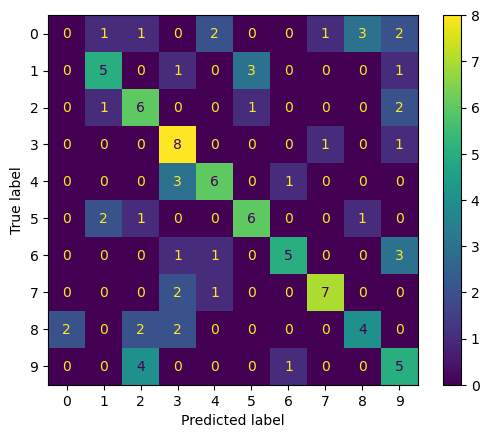

In [34]:
batch_size = 50

train_dataset = AudioDataSet(train_features, train_labels)                      #create training dataset and labels
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)   #load training dataset in batches of 50 samples
                                                                        
val_dataset = AudioDataSet(val_features, val_labels)                            #create validation dataset and labels
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)      #load validation dataset in batches of 50 samples

test_dataset = AudioDataSet(test_features, test_labels)                         #create test dataset and labels
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    #load test dataset in batches of 50 samples

#User defined parameters
num_blocks = 6       #number of blocks 
activation = 1       #1:ReLU    2:Sigmoid    3:Tanh 
pool = 1             #1:Average 2:Maximum
optimiser = 1        #1:Adam    2:SGD

model = ConvNet(in_channels=128, out_channels=16, kernel_size=3, num_blocks=num_blocks, num_classes=10, activation=activation, pool=pool)     #create instance of CNN

if optimiser == 1:
    optimiser = torch.optim.Adam(model.parameters())                   #create instance of Adam optimiser
    func3 = "Adam"
elif optimiser == 2:
    optimiser = torch.optim.SGD(model.parameters())                    #create instance of SGD optimiser
    func3 = "SGD"
else:
    assert('Incorrect optimiser index')

BCEloss = nn.CrossEntropyLoss()                                         #create instance of Binary Cross Entropy loss
num_epochs = 100                                                         #number of iterations/epochs

if activation == 1:
    func = "ReLU"
elif activation == 2:
    func = "Sigmoid"
elif activation == 3:
    func = "Tanh"

if pool == 1:
    func2 = "Average"
elif pool == 2:
    func2 = "Maximum"
    
print(f"Model training with: {num_blocks} blocks, {func} Activation, Adaptive {func2} Pooling and {func3} Optimiser for {num_epochs} epochs.")

my_config = {"Number of blocks" : num_blocks, "Activation" : activation, "Optimiser" : optimiser, "Pooling" : pool, "Number of epochs" : num_epochs}
wandb.init(project='Genre_classifier', entity='jazz-54-hate-club', reinit=True, config=my_config)

train_loop(model, train_loader, optimiser, BCEloss, num_epochs)         #run training loop for 100 epochs
validate_loop(model, val_loader, BCEloss, num_epochs)                   #run validation loop
test_labels, test_preds = test_loop(model, test_loader, BCEloss)        #run testing loop
                                                                         
matrix = sklearn.metrics.confusion_matrix(test_labels,test_preds)   #create confusion matrix using testing dataset
disp = sklearn.metrics.ConfusionMatrixDisplay(matrix)               #add matrix to displayable plot variable

#Output: display confusion matrix and save figure to file
disp.plot()                
#plt.savefig('GenreClassifierCustomisable.png')
plt.savefig(f'Testing{num_blocks},{func},{func2},{func3},{num_epochs}.png')